# Investigating the Gapminder Systema Globalis Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
</ul>

<a id='intro'></a>
## Introduction

The name "Systema Globalis" is inspired by [Systema Naturae](https://en.wikipedia.org/wiki/Systema_Naturae); the first systematic compilation of all living things from year 1735, by the Swedish Scientist Carl von Linné. The goal of Systema Globalis is to compile all public statistics; Social, Economic and Environmental; into a comparable total dataset.

In this exercise, we will work through the process of transforming the Systema Globalis data files into a workable dataframe, and then using that dataframe to do a few rudimentary analyses of the data meant to model the kind of exploratory data analysis might perform when first presented with a new dataset. 

Our initial exploration will give us information on which country's citizens have seen the largest increase in individual wealth (measured as income per person w/ ppp and inflation adjustments) over the past 68 years. Our observations from this exploration lead directly to a secondary question which will attempt to extract more detailed information about a particular event we saw in our first exploration. 

Finally, we will shift gears and do a different type of analysis to see if our dataset can provide us with any evidence as to whether or not a particular pharmaceutical breast cancer treatment is effective in reducing breast cancer mortality. 


### Data
This is the main dataset used in tools on the official Gapminder website. It contains local &amp; global statistics combined from hundreds of sources.

For the purposes of this demonstration, we will be using the glob module for file manipulation, pandas and numpy for working with the data, and matplotlib's basic pyplot suite (including its pandas integration) for visualization.

_This exercise is intended to illustrate the choices an analyst must make at each point of the early data analysis process, from the initial data-wrangling to the interpretation of exploratory findings. The process shown is not presented as an optimal route. Rather, the intent is to provide a realistic look at how a curious analyst might approach an unfamiliar dataset, including pitfalls they may encounter._ 

In [1]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The Systema Globalis data consists of longitudinal country-level data on over 500 indicators of social, economic, health, environmental, and other comparative measures. The data on each indicator is contained in its own csv file, organized by country (geo) and year of measurement (time). 

### General Properties

Due to the multi-file structure of this dataset, analysis involving more than one indicator requires file operations to parse, read, and merge the data from each target indicator. The glob module simplifies this process, allowing for filename 'globbing' based on wildcard searches of filenames. This provides one method of subsetting the files and extracting only the data we are interested in analyzing. 

For example: 

In [2]:
# Returns only the filenames of 'datapoint' csv files containing literacy data:
datafiles_literacy = glob.glob('*datapoints*literacy*.csv')
print(np.array(datafiles_literacy)[:3], '\n\n')

# Returns only the filenames of 'datapoint' csv files containing energy data:
datafiles_energy = glob.glob('*datapoints*energy*.csv')
print(np.array(datafiles_energy)[:3])

['ddf--datapoints--literacy_rate_adult_female_percent_of_females_ages_15_above--by--geo--time.csv'
 'ddf--datapoints--literacy_rate_adult_male_percent_of_males_ages_15_and_above--by--geo--time.csv'
 'ddf--datapoints--literacy_rate_adult_total_percent_of_people_ages_15_and_above--by--geo--time.csv'] 


['ddf--datapoints--energy_from_solid_biofuels_percent--by--geo--time.csv'
 'ddf--datapoints--energy_production_per_person--by--geo--time.csv'
 'ddf--datapoints--energy_production_total--by--geo--time.csv']


In the alternative, we can simply read all of the data into Python, and hold off on trimming it down or subsetting it until after its all been processed.  This will be more computationally intensive than importing only a target subset, and would be impractical (or even impossible) with very large datasets, but there is a certain appeal to compiling all of the relevant data in a single place and while complex, this dataset is not so large to make this too unweildly, so an analyst may opt for this route even though it may bring with it some complications.  

In [3]:
datafiles_all = glob.glob('*datapoints*.csv')

The gapminder data is particularly well suited to exploratory data analysis because it is largely 'pre-cleaned'. Each table shares a uniform format, making it very easy to read in and merge the data from multiple indicators. 

While data 'wrangling' can be a complex, time-consuming process, especially when dealing with messy data or data from multiple sources, it can be accomplished here with relative ease.

In [4]:
# create empty dictionary into which we will read all of our data files
ref = {}

# loop through filenames, extracting indicator name from filename, and values
# from each file itself
for filename in datafiles_all:
    key = filename.partition('datapoints--')[2].partition('--')[0]
    data = pd.read_csv(filename)
    # index each table by country and cast longitudinal progression to columns 
    data = data.pivot(index='geo', columns='time')
    # incorporate second-level index (indicator name), necessary when merging
    # multiple indicators 
    data = data.stack(level=0)
    data.index.set_names('indicator', level=1, inplace=True)
    # dictionary entry: key = indicator name, value = reformatted dataframe
    ref[key] = data

We now have a reference dictionary containing the entire gapminder dataset. As mentioned eariler, this "everything in one place" approach is sub-optimal for a number of reasons, one of which will become apparent soon. 

We will finish the process by concatenating all of these individual tables into a single master dataframe. Again, we ensured that this would go smoothly by reindexing and reshaping in the previous step.

In [5]:
master = pd.concat(ref.values())
master = master.sort_index()
# let's take a look at some attributes of our master dataframe
print("column names are:", master.columns)
print("index names are:", master.index.names)
print("shape is:", master.shape)
print("total missing values:", master.isna().sum().sum())
print("non-missing values:", master.count().sum())

column names are: Int64Index([1086, 1100, 1279, 1290, 1300, 1309, 1348, 1349, 1351, 1352,
            ...
            2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
           dtype='int64', name='time', length=409)
index names are: ['geo', 'indicator']
shape is: (91331, 409)
total missing values: 34084125
non-missing values: 3270254


__Whoa__, this is a bit of a mess. There are datapoints going back all the way to the 11th century, and there are even points out into the future! How is that possible? 

Furthermore, our table contains over 33 million missing values, and fewer than 3 million actual values. In other words, the majority of our dataframe is pretty much useless.

A closer look at our indicators shows that while most of the indicators contain observed values, some are projections. This explains the values for future years. We could fix this by not loading in those particular indicators, or by filtering our data to a specific timeframe. 

How about those missing values though?  Let's take a closer look:

In [6]:
print(master.count().describe())

count      409.000000
mean      7995.731051
std      14165.415767
min          1.000000
25%         69.000000
50%       3872.000000
75%       4861.000000
max      70614.000000
dtype: float64


Ok, that explains a lot. If there were no values missing in our table, we would expect to see almost 88,000 observations for each year. Here we see that 75% of years contain fewer than 5000 observations, that there is at least one year that contains only 1 single value, and that even the year for which we have the most information still contains almost 30,000 missing values.   

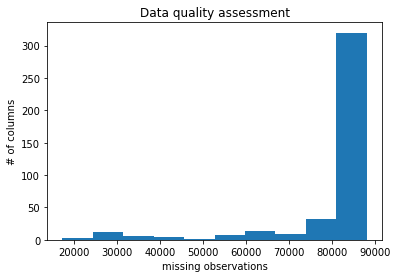

In [7]:
plt.xlabel('missing observations')
plt.ylabel('# of columns')
plt.title('Data quality assessment')
plt.hist(88000 - master.count())
plt.show()

### Data Cleaning
In our attempt to put everything in one place, we created a HUGE but mostly empty dataset. The most obvious culprits based on our cursory look are the very early years that contain very few observations, and the future (projection) years which also contain relatively few observations. 

There are some less obvious complications though:
1) Countries whose names change
2) Countries for which very little data has been collected
3) Indicators which only contain data for a limited timeframe

These can each be addressed, whether by 
1) limiting the scope of analysis to only certain countries, 
2) certain indicators, or 
3) certain time-periods 

Each of these solutions moves us away from the 'everything in one place' approach we were initially going for, but would also prevent the replication of tons of empty values.

What follows are two examples of how the assembly process used earlier could have been modified to reduce the size of the dataframe output based on user-determined filtering criteria. 

In [8]:
# Filtering by time and indicator 
d1 = {}

for filename in datafiles_all:
    # read in only filenames containing certain keywords
    if re.search('income|cancer.deaths.*100000', filename):
        key = filename.partition('datapoints--')[2].partition('--')[0]
        data = pd.read_csv(filename)
        # 'pre-cleaning' step to exclude data from earlier than 1950, and 
        # exclude projections
        data = data[data.time >= 1950]
        data = data[data.time <= 2018] 
        data = data.pivot(index='geo', columns='time')
        data = data.stack(level=0)
        data.index.set_names('indicator', level=1, inplace=True)
        d1[key] = data

In [9]:
# Filtering by time and country
d2 = {}

for filename in datafiles_all:
    key = filename.partition('datapoints--')[2].partition('--')[0]
    data = pd.read_csv(filename)
    data = data[data.time >= 1950]
    data = data[data.time <= 2018] 
    # from each indicator, retain only the data for the following countries
    data = data.loc[(data.geo == 'usa') | (data.geo == 'ger') |
                    (data.geo == 'chi') | (data.geo == 'jap') | 
                    (data.geo == 'aus')]
    data = data.pivot(index='geo', columns='time')
    data = data.stack(level=0)
    data.index.set_names('indicator', level=1, inplace=True)
    d2[key] = data

In [10]:
# reassembling the datasets
t1 = pd.concat(d1.values())
t1 = t1.sort_index()
print("column bounds are:", (t1.columns.min(), t1.columns.max()))
print("shape of t1 is:", t1.shape)
print("total missing values in t1:", t1.isna().sum().sum())
print("non-missing values in t1:", t1.count().sum(), '\n')

t2 = pd.concat(d2.values())
t2 = t2.sort_index()
print("shape of t2 is:", t2.shape)
print("total missing values in t2:", t2.isna().sum().sum())
print("non-missing values in t2:", t2.count().sum())

column bounds are: (1950, 2018)
shape of t1 is: (4336, 69)
total missing values in t1: 158845
non-missing values in t1: 140339 

shape of t2 is: (997, 69)
total missing values in t2: 36979
non-missing values in t2: 31814


As you can see, by limiting the data we read in during our initial sweep of the datafile directory, we reduced the size of our working datasets, and also dramatically cut down on the number of missing values we would now have to deal with during analysis. 

Of course, we could accomplish the same thing by simply subsetting our comprehensive (but bloated) 'master' dataset since we've already assembled it. 

In [11]:
# Filtering by time and indicator

master_t1 = master.loc[:, 1950:2018].filter(
    regex='income|cancer.deaths.*100000', axis=0)
print(master_t1.shape == t1.shape)

True


In [12]:
# Filtering by time and country

master_t2 = master.loc[['usa', 'ger', 'chi', 'jap', 'aus'],
                       1950:2018].dropna(how='all', axis=0)
print(master_t2.shape == t2.shape)

True


In this case, neither approach is purely 'better' or 'worse', but as noted before, the performance burden of building an initial comprehensive dataset could be dramatic with larger multi-dimensional data, so pre-processing is generally preferred. 


For the purpose of this exercise we will create a third subset which contains only data for the United States going back no earlier than the 20th century. This will be our most restrictive set thus far.

In [13]:
usa = master.loc['usa', 1900:2018].dropna(how='all', axis=0)
print(usa.shape)

(500, 119)


As we can see, even after restricting our data to that from a single country, we're still left with 504 different observations for each of 119 years. While it is nice to be able to create these subsets of data with relative ease, it seems that their practical value may end up being somewhat limited for the purposes of exploratory data analysis. 

The derivation of any meaningful insights will probably require looking at only one or two indicators at a time. Aha! Speaking of insights, now we should have a better idea why the folks who maintain the gapfinder data decided to store each indicator in its own separate table. Surely they understood that the data would be much easier to navigate that way! 

<a id='eda'></a>
## Exploratory Data Analysis

Now that we've experimented with trimming and cleaning the data, we're ready to move on to exploration. We'll compute some basic statistics and create crude visualizations with the goal of identifying trends within a single variable over time or relationships between variables. Some exploration is visual, and some may is computational.

For now, we are going to take a look at a single indicator: "income per person, gdp per capita ppp inflation adjusted". This is a general indicator which might be useful as a rough guide to estimating how much the 'average' citizen of a country earns as income in a given year. This value is already adjusted for inflation. 

We will subset out this indicator and create a new dataframe consisting of only its values worldwide since 1950. We will filter this from t1, a subset table we created earlier which contains all indicators including the word 'income' and is already limited to data between 1950 and 2018.  

(204, 69)


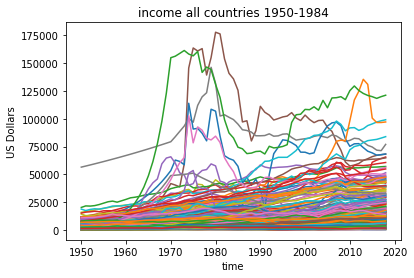

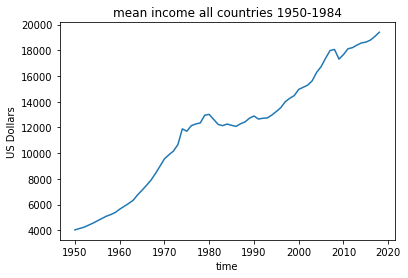

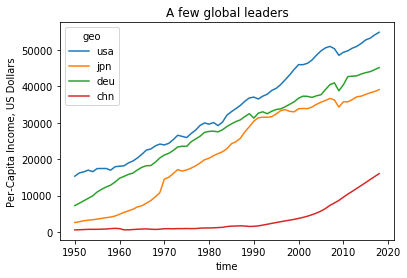

In [14]:
incomepp = t1.filter(like='income_per_person_gdppercapita_ppp_inflation_adjusted',
                     axis=0)
# Dropping the indicator index (since we're only looking at a single 
# indicator right now) may make our data easier to manipulate
incomepp.index = incomepp.index.droplevel(1)
print(incomepp.shape)
incomepp.T.plot(legend=False, title='income all countries 1950-1984')
plt.ylabel('US Dollars')
plt.show()
incomepp.mean().plot(legend=False, title='mean income all countries 1950-1984')
plt.ylabel('US Dollars')
plt.show()
incomepp.loc[['usa', 'jpn', 'deu', 'chn']].T.plot(title = 'A few global leaders')
plt.ylabel('Per-Capita Income, US Dollars')
plt.show()

We can see, just by looking at the graphical representation of this income data, that there has been a clear upward trend in individual wealth over the past 68 years. We can see in our first graph that some of the highest-earning countries took a major hit during the 1980s. The second chart shows that global growth also stalled a bit during this same time period. We may want to return to this question later.

Generally speaking, we can't tell much about individual countries by looking at graphs of aggregate calculations or all of our data at once. We are able to focus a bit more on individual countries by selecting only a few as we did in the third plot, but lets start digging a little deeper and asking specific questions.

### 1) Which country's citizens have seen the largest increase in individual wealth (measured as income per person w/ ppp and inflation adjustments) over the past 68 years?

This should be relatively easy to calculate, and thus makes for a good starting point. In order to measure the increase (or decrease) in income, we simply look at the difference between the starting and ending points. This will give us a single value for each country, and we can then sort those values to determine the biggest 'winners' and 'losers'. 

In [15]:
raw_growth = (incomepp.iloc[:,-1]-incomepp.iloc[:,0])
percent_growth = (raw_growth/incomepp.iloc[:,0]*100).dropna().sort_values(ascending=False)
print(percent_growth.head(), '\n\n', percent_growth.tail(), '\n\n')

print("United States percent growth from 1950-2018:", round(percent_growth['usa'],2))


geo
qat    7450.41
are    5548.26
kor    4536.44
gnq    4180.13
chn    2888.43
dtype: object 

 geo
hti   -25.0328
som   -36.9107
caf   -43.1518
lbr   -46.5287
cod   -52.1046
dtype: object 


United States percent growth from 1950-2018: 258.41


#### Conclusions
Wow, this is shocking! First of all, look at those gains in the top five countries. Remember, these are percentages, so that 4536 for Korea means that income has increased 45 times over. On the other hand, the citizens of some countries have actually experienced a DECREASE in income over the past 68 years. Somalia, the Central African Republic, Haiti, Liberia, and the Democratic Republic of the Congo experienced the worst negative gain out of all of the tracked countries, with income in the Congo decreasing by over 50%. 

It would seem that individuals in Quatar, the UAE, Korea, China, and Equatorial Guinea have made incredible gains over the past 68 years. This would be an excellent jumping-off point for further investigation into these individual countries. Why did the top 5 do so well? Why did the bottom 5 do so poorly? These questions are beyond the scope of this exercise, but you get the idea.

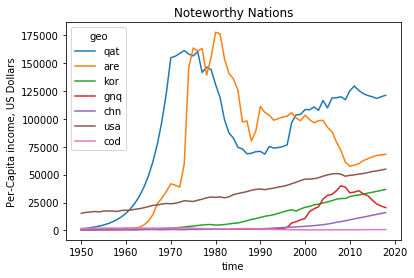

In [16]:
incomepp.loc[['qat', 'are', 'kor', 'gnq', 'chn', 'usa', 'cod']].T.plot(
    title = 'Noteworthy Nations')
plt.ylabel('Per-Capita income, US Dollars')
plt.show()

In taking one more look at these countries, we observe another potentially interesting phenomena involving the UAE and Equatorial Guinea over the years from 2000 to the present day. Perhaps that can fuel another investigation at a later date.

For now, we will revisit an earlier observation to explore it in a bit more depth. 

### 2) Which countries experienced the most significant downturn during the 1980s, the decade during which global average income seemed to stop growing.

We can start by approaching this question just like we did the previous question. We want to know which countries performed the worst on our selected indicator for the years between 1980 and 1990. We can simply repeat the process to get us started:

geo
kwt   -69796
are   -66455
qat   -59972
brn   -46925
sau   -41865
dtype: object 
 geo
sgp    13445
omn    13598
lux    21331
abw    22712
cym    23549
dtype: object 

The average change over this decade was: -136.0


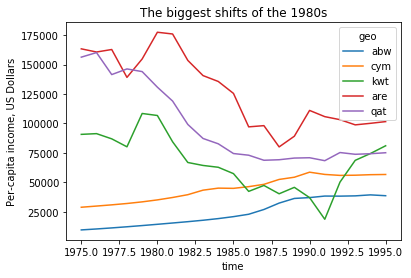

In [17]:
change_80 = (incomepp.loc[:,1990]-incomepp.loc[:,1980]).sort_values().dropna()
print(change_80.head(5),'\n', change_80.tail(5),
      '\n\nThe average change over this decade was:',
      round(change_80.mean(),1))

incomepp.loc[['abw', 'cym', 'kwt', 'are', 'qat'], 1975:1995].T.plot(
    title = 'The biggest shifts of the 1980s')
plt.ylabel('Per-capita income, US Dollars')
plt.show()

#### Conclusions
The most dramatic drops were seen in Kuwait, Saudi Arabia, and Qatar. Individuals in those countries were much worse off than average during the 80s in terms of the volatility of their income. Meanwhile, incomes in certain other countries continued to grow.

While again this would be outside of the scope of this exploration, a statistician might use more sophisticated techniques to identify 'events' of this nature: time periods where fluctuation in the value of an indicator appear to be caused by something other than normal variation.

For now, let us step away from economic indicators. With access to such a rich dataset, the questsions an analyst might ask are almost limitless. Here we'll look at a healthcare-related indicator.

### 3) Was there a reduction in the breast cancer mortality rate in American women following the introduction of tamoxifen, a pharmaceutical breast cancer treatment that was FDA approved in 1978?** 

We will look at the number of American women who died from breast cancer before and after a particular treatment was approved by the FDA. We know which indicator and span of years we're interested in. We also know that the question applies to the United States only, but it may be helpful to look at data on breast cancer worldwide, so we will begin by filtering out our target indicator and dropping years in which there is no data at all, but we will not subset out only USA data to start with.

*\**The following is intended only as a demonstration of the exploratory data analysis process.*

In [18]:
bcancer = master.filter(regex='breast_cancer.deaths',
                        axis=0).dropna(how='all', axis=1)
bcancer.index = bcancer.index.droplevel(1)
print(bcancer.shape)
print(bcancer.columns)
print(bcancer.T.notna().sum().describe())

(198, 67)
Int64Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
            1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
            2016],
           dtype='int64', name='time')
count    198.000000
mean      35.404040
std       14.301623
min        1.000000
25%       27.000000
50%       27.000000
75%       39.000000
max       67.000000
dtype: float64


Ok, we have data for 1950 through 2016. That's perfect, since the drug was approved about halfway through that timeframe. Looks like we've got data from 198 countries, but some of those countries have only one single value. Let's get rid of those. We can't use them in our analysis. 

In [19]:
bcancer = bcancer[bcancer.T.notna().sum() > 1]
print(bcancer.shape)
print(bcancer.T.notna().sum().describe())

(196, 67)
count    196.000000
mean      35.755102
std       13.941682
min       27.000000
25%       27.000000
50%       27.000000
75%       39.750000
max       67.000000
dtype: float64


We eliminated two countries that only had a single value. The remaining 196 countries each have at least 27 non-na observations. 

We also have to make sure that every country remaining has at least one data point available before 1978 and at least one after 1978 so we will be able to calculate pre- and post-tamoxifen averages: 

In [20]:
print((bcancer.T.loc[:1978].notna().sum() == 0).sum(),
     (bcancer.T.loc[1979:].notna().sum() == 0).sum())

144 0


Looks like all of the countries have data going back to 1978, but 144 of the remaining countries don't have any data prior to then. Unfortunately, we have to exclude those from our analysis:

In [21]:
bcancer = bcancer[bcancer.T.loc[:1978].notna().sum() > 1]
bcancer.shape

(52, 67)

This leaves us with 52 countries that contain at least one observation prior to 1978 and at least one observation in a later year.

In [22]:
# Create group labels
bcancer = bcancer.T.astype(float)
bcancer.loc[:1978, 'drug'] = 'pre-Tamoxifen'
bcancer.loc[1978:, 'drug'] = 'post-Tamoxifen'

# take a look at the means by group to ensure the grouping operation worked
allstats = bcancer.groupby('drug').mean()
allstats.unstack().head(10)

geo  drug          
arg  post-Tamoxifen    25.719689
     pre-Tamoxifen     20.557018
aus  post-Tamoxifen    21.797256
     pre-Tamoxifen     19.947929
aut  post-Tamoxifen    22.533923
     pre-Tamoxifen     17.607478
bgr  post-Tamoxifen    18.832769
     pre-Tamoxifen     10.940857
blz  post-Tamoxifen    12.366307
     pre-Tamoxifen      6.580056
dtype: float64

We can now get a very rough look at whether the mean mortality rate in the 'post-treatment' years is different from the mortality rate prior to the treatment's FDA approval (in countries that have at least one observation during each of those two time periods).  

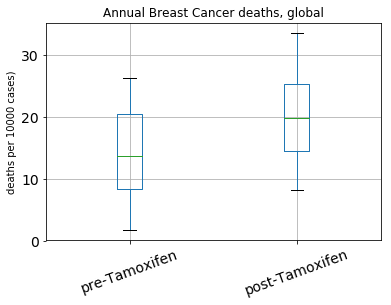

In [23]:
allstats.T[['pre-Tamoxifen', 'post-Tamoxifen']].boxplot(rot=20, fontsize=14)
plt.title("Annual Breast Cancer deaths, global")
plt.ylabel('deaths per 10000 cases)')
plt.show()

There is a noticable difference between the death rate in the years prior to and after 1978. Worldwide, there were, on average more deaths per 10000 breast cancer cases in more recent years than there were in the years prior to 1978. 

We can observe this global data as a reference, but it isn't informative to our research question.  As mentioned earlier, FDA approval is of primary importance to the adoption of medical treatments in the United States only, so we must limit our data to this single country in order to assess the event we wish to observe.*

*\*note: We could have begun by subsetting out only the data from the USA, and if this dataset were much larger than it is, doing so might have been a wiser decision for performance reasons. In this case, the forward-thinking desire to create a cleaned global "bcancer" dataframe for reference and further exploration outweighed the need to be efficient.*

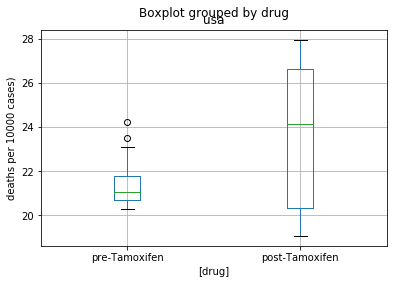

In [24]:
# Subset out only the data from the United States
usa_bc = bcancer[['usa', 'drug']]

usa_bc.boxplot(by='drug', positions = (2, 1))
plt.ylabel('deaths per 10000 cases)')
plt.show()

#### (non)Conclusions

This rough visual assessment shows an increase in the average breast-cancer mortality rate for American women post 1978 and an increase in variance. We do not see a decrease in breast cancer mortality associated with the FDA approval of Tamoxifen. We can't draw any conclusions without a much more sophisticated and controlled analysis. 

Such an analysis is beyond the scope of this exercise, but we can at least note some of the issues we would need to consider if we were to make a more serious inquiry into this research question:  

#### Lack of domain-level knoweldge:
1) Is Tamoxifen prescribed to slow the progression of breast-cancer, or only to improve the quality of life of those suffering from the disease? If the latter, we asked the wrong research question. 

2) The drug was approved in 1978, but when did doctors actually start using it, and is it still used? Our time-based grouping could be completely incorrect. For all we know, we could be looking into a drug that was only used in practice for one year before being supplanted by a superior treatment, or maybe even never made it into widespread clinical use at all. 
  
#### Confounding factors:
Even if we did more research and learned that Tamoxifen was in fact prescribed widely starting in 1978 and continuing to today, we would still need to be very careful with what inferences we try to draw from the data. Our very crude analysis doesn't take into account any developments in breast-cancer diagnostics or breast-cancer treatments other than Tamoxifen between 1950 and the present day, either of which could have significant impacts on the reporting of this indicator.   


## Wrap-up:

Thank you for joining me in exploring Systema Globalis!! I hope that this has helped you gain a better understanding of what a data analyst actually does "behind-the-scenes". We only scratched the surface of this tremendous dataset during this demonstration, but I encourage you to revisit the dataframes we cleaned up earlier to start asking your own research questions and doing your own exploratory data analysis. 